1. **Restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart)
2. **Run all cells** (in the menubar, select Cell$\rightarrow$Run All).
3. __Use the__ `Validate` __button in the Assignments tab before submitting__.

__Include comments, derivations, explanations, graphs, etc.__ 

You __work in groups__ (= 3 people). __Write the full name and S/U-number of all team members!__

---

# Assignment 4 (Statistical Machine Learning 2024)
# **Deadline: 21 December 2024**

## Instructions
* Fill in any place that says `YOUR CODE HERE` or `YOUR ANSWER HERE` __including comments, derivations, explanations, graphs, etc.__ 
Elements and/or intermediate steps required to derive the answer have to be in the report. If an exercise requires coding, explain briefly what the code does (in comments). All figures should have titles (descriptions), axis labels, and legends.
* __Please use LaTeX to write down equations/derivations/other math__! How to do that in Markdown cells can be found [here](https://www.fabriziomusacchio.com/blog/2021-08-10-How_to_use_LaTeX_in_Markdown/), a starting point for various symbols is [here](https://www.overleaf.com/learn/latex/Mathematical_expressions).
* Please do __not add new cells__ to the notebook, try to write the answers only in the provided cells. Before you turn the assignment in, make sure everything runs as expected.
* __Use the variable names given in the exercises__, do not assign your own variable names. 
* __Only one team member needs to upload the solutions__. This can be done under the Assignments tab, where you fetched the assignments, and where you can also validate your submissions. Please do not change the filenames of the individual Jupyter notebooks.

For any problems or questions regarding the assignments, ask during the tutorial or send an email to charlotte.cambiervannooten@ru.nl and janneke.verbeek@ru.nl .

## Introduction
Assignment 4 consists of:
1. Bayesian inference in binary response problem (50 points);
2. __The EM algorithm for doping detection (50 points)__;
3. Gibbs sampling and Metropolis-Hastings (50 points);
4. State-Space models (50 points).

## Libraries

Please __avoid installing new packages__, unless really necessary.

In [304]:
import IPython
assert IPython.version_info[0] >= 3, "Your version of IPython is too old, please update it to at least version 3."

import numpy as np
import matplotlib.pyplot as plt

# Set fixed random seed for reproducibility
np.random.seed(2022)

## The EM algorithm for doping detection (50 points)
In a certain hypothetical sport, a banned substance has become popular as a performance enhancing drug, as its presence is hard to establish in blood samples directly. Recently, it has been discovered that users of the drug tend to show a strong positive correlation between concentrations of two other quantities, $x_1$ and $x_2$, present in the blood. In contrast, 'clean' athletes tend to fall in one of two or three groups, that either show no or a negative correlation between $x_1$ and $x_2$. Unfortunately, as each sample contains only a single, instantaneous, measurement for each variable, it is not possible to establish this correlation from the sample. However, in many cases it is possible to distinguish to which _class_ a certain sample belongs by also looking at the values of two other measured variables, $x_3$ and $x_4$: certain combinations of measured values are often typical for one class but highly unusual for others.

After a high profile event, a large scale test has resulted in 2000 samples. Rumours suggest the number of positives could be as high as 20\%. However, the exact relationship between different classes and typical $\mathbf{x}$ values is still not clear. This is where the EM-algorithm comes in ...

The blood sample measurements are modelled as a mixture of $K$ Gaussians, one for each class
\begin{equation}
p(\mathbf{x}|\mathbf{\mu}, \mathbf{\Sigma}, \mathbf{\pi}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\mathbf{\mu}_k, \mathbf{\Sigma}_k)
\label{Gmm}
\tag{1}
\end{equation}
where $\mathbf{x} = [x_1, x_2, x_3, x_4]$ represents the values for the measured quantities in the blood sample, $\mathbf{\mu} = \{\mathbf{\mu}_1, \ldots, \mathbf{\mu}_K\}$ and $\mathbf{\Sigma} = \{\Sigma_1, \ldots, \Sigma_K\}$ are the means and covariance matrices of the Gaussians for each class, and $\mathbf{\pi} = \{\pi_1, \ldots, \pi_K\}$ are the mixing coefficients in the overall data set.

We first load the data and set $N$ to the number of datapoints and $D$ to the number of variables in the data set $X$.

In [305]:
# Load data
X = np.loadtxt("doping_mixdata.txt")
N, D = X.shape

1. Try to give an estimate of the number, size and shape of the classes in the data by plotting the distribution of the variables, e.g, using `plt.hist`, `plt.scatter` or `scatter3()`.

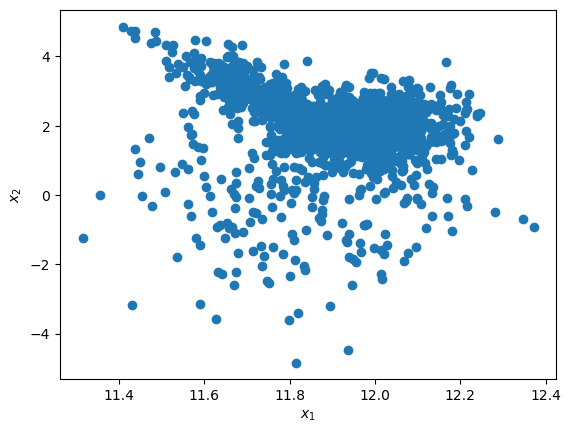

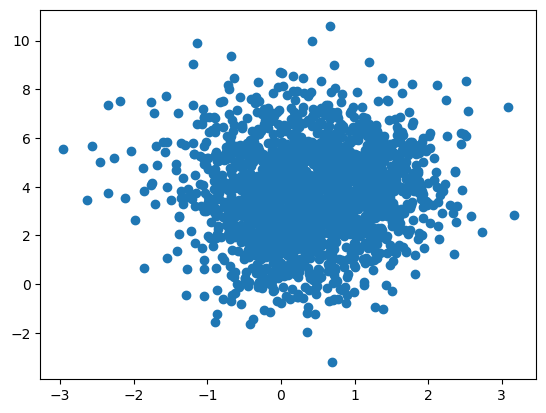

c:\Users\stian\miniconda3\envs\sml\Lib\site-packages\matplotlib\collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


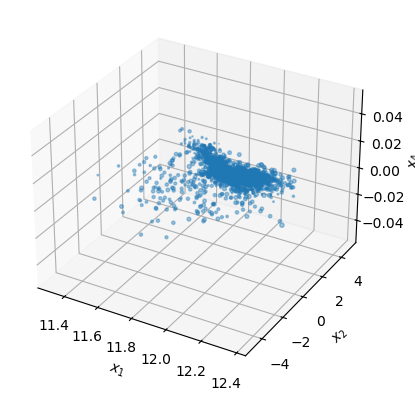

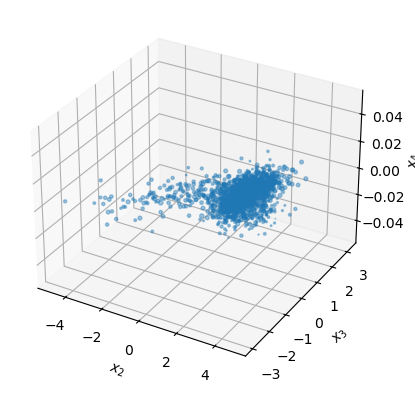

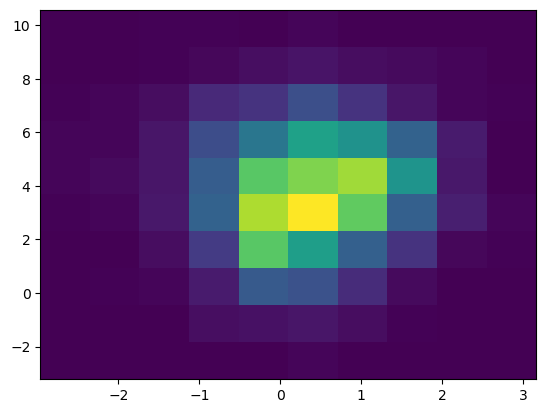

In [306]:
"""
Experiment with different plots.
"""
# YOUR CODE HERE
plt.scatter(X[:,0], X[:,1])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()
plt.scatter(X[:,2], X[:,3])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# 3d scatter. a bit zoomed out so hard to look at
plt.scatter(X[:,0], X[:,1], X[:,3], alpha = 0.4)
ax.set_xlabel("$x_1$")
ax.set_ylabel("$x_2$")
ax.set_zlabel("$x_4$")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")
# 3d scatter. a bit zoomed out so hard to look at
plt.scatter(X[:,1], X[:,2], X[:,3], alpha = 0.4)
ax.set_xlabel("$x_2$")
ax.set_ylabel("$x_3$")
ax.set_zlabel("$x_4$")
# This one I think kind of actually locates the weird data points though
plt.show()


# basically same as a 2d scatter
plt.hist2d(X[:,2], X[:,3])
plt.show()

YOUR ANSWER HERE

from plot 4 here, we're starting to identify some suspicious data. It looks like there's a large majority of people that  $x_3$ and $x_4$ values in a certain cluster, as seen from that scatter plot, but shows that things that have $x_2$ less than -2 seem to belong to a different cluster than the others, while $x_2$ between -2 and 2 seems to be in the main cluster of people.

2. Implement an EM-algorithm using the description and formulas given in Bishop, $\S9.2.2$. Use variable $K$ for the number of classes and choose a priori equal mixing coefficients $\pi_k$. Initialize the means $\mathbf{\mu}_k$ to random values around the sample mean of each variable, e.g. set $\mu_{k,1}$ to $\bar{x}_1 + [-1 \leq \epsilon \leq +1]$. Initialize the $\mathbf{\Sigma}_k$ to diagonal matrices with reasonably high variances, e.g. `random.randint(2,6)`, to avoid very small responsibilities in the first step. Make sure the EM-loop runs over at least 100 iterations. Display relevant quantities, at least the log likelihood (9.28), after each step so you can monitor progress and convergence.

In [307]:
"""
Implement the EM algorithm.
"""
from scipy.stats import multivariate_normal

def log_mvrnorm(x, mu, sigma):
  """
  multivariate normal

  utility function for calculating the log probability of all data-points given mean vector and covariance matrix
  """
  d = x.shape[1]
  sign, log_det_sigma = np.linalg.slogdet(sigma)
  diff = x-mu
  sigma_inv = np.linalg.inv(sigma)
  p = -0.5 * (d * np.log(2*np.pi) + (log_det_sigma) + np.sum((diff@sigma_inv)* diff, axis=1))
  return p

# YOUR CODE HERE
def em(X:np.ndarray, K:int=2, max_iter:int=500, tol=1e-9):

  N, D = X.shape

  # initialise means, covariances and mixing coefficients
  x_bars = np.tile(np.mean(X, axis=0), K).reshape(K, D)
  # sd = np.std(X, axis=0)
  sd=1
  noise = np.random.uniform(-1, 1, K*D).reshape(K, D)
  means = x_bars + noise*sd
  I = np.eye(D)
  v = np.random.randint(2,6, D*D*K).reshape(K, D, D)
  covs = (I + np.zeros((K, D, D))) * v
  class_priors = np.full(K, 1/K)
  
  ll_old = float("inf")
  for i in range(max_iter):
    
    # evaluate responsibilities, E step
    log_probs = np.array([np.log(class_priors[k])+log_mvrnorm(X, means[k], covs[k]) for k in range(K)])
    log_probs = log_probs - np.max(log_probs, axis=0) # num stability
    resp = np.exp(log_probs).T
    resp = resp / np.sum(resp, axis=1, keepdims=True)
  
    # re-estimate params, M step
    N_k = np.atleast_2d(np.sum(resp, axis=0)).T
    means = 1/N_k * resp.T@X
    covs = np.array([1/N_k[k] * ((np.atleast_2d(resp[:,k]).T * (X-means[k]))).T@(X-means[k]) for k in range(K)])
    class_priors = np.array(N_k/N)

    # eval log-lik
    ll = np.sum([np.log(class_priors[k])+log_mvrnorm(X, means[k], covs[k]) for k in range(K)])

    ll = np.sum(np.logaddexp.reduce([np.log(class_priors[k])+log_mvrnorm(X, means[k], covs[k]) for k in range(K)]))



  # print(ll)
    if (np.abs(ll_old-ll)) < tol:
      print(f"converged in {i} iterations")
      break
    else:
      ll_old = ll

  if i == max_iter-1:
    print("did not converge")
  return ll, means, covs, class_priors, resp


Now implement a plot routine that plots the ${x_1,x_2}$ coordinates of the data points, and color each data point  according to the most probable component in the mixture model.

In [308]:
"""
Plot routine.
"""
# YOUR CODE HERE
def plot_data_comps(X, resp, K:int=2):
  x1 = X[:,0]
  x2 = X[:,1]

  assignment = np.argmax(resp, axis=1)

  fig = plt.figure()
  ax = fig.add_subplot()
  
  for k in range(K):
    x = x1[assignment==k]
    y = x2[assignment==k]
    ax.scatter(x, y, label=f"cluster {k+1}")

  plt.legend()
  plt.show()

3. Set $K=2$, initialize your random generator and run the EM-algorithm on the data. Try different random initializations.

    _(Should converge within 50 steps to two clusters, accounting for $\pm$1/3 resp. 2/3 of the data)._

    Plot the ${x_1,x_2}$ coordinates coloured according to the most probable component.
    

In [323]:
"""
Run the EM algorithm. 
"""
ll, means, covs, class_priors, resp = em(X, K = 2)
print(ll)

print(np.sum(np.argmax(resp,axis=1)))

converged in 123 iterations
-7058.126253435988
1413


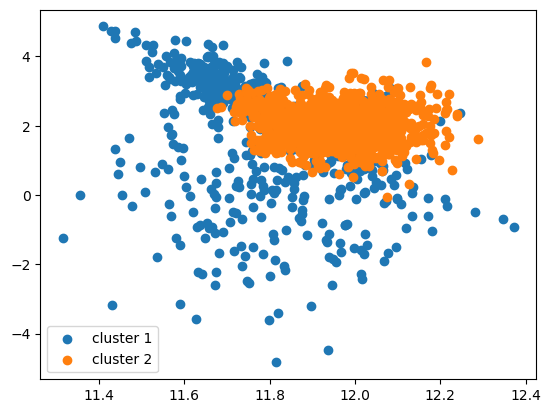

In [324]:
"""
Plot the most probable component. 
"""
# YOUR CODE HERE
plot_data_comps(X, resp)

Describe what happens and compare the results of the different initializations.

The main difference between initializations seems to be which cluster gets assigned to component one, and which to component two. Other than that, it seems to find that the vast majority of the data - the clump in the top/middle, belongs to component 1, and the other - the spread in the bottom/left, belongs to component 2.

Compute the correlation coefficients
\begin{equation}
\rho_{12} = \frac{\mathrm{cov}[x_1,x_2]}{\sqrt{\mathrm{var}[x_1] \mathrm{var}[x_2]}}
\label{correlationcoeff}
\tag{2}
\end{equation}
of each of the components (i.e., use their covariance matrices to compute variances and covariances in (\ref{correlationcoeff}), see also Bishop, eq. (2.93).

**Hint**: According to Wikipedia, the correlation is none if $|\rho|<0.1$, small if $0.1<|\rho|<0.3$, medium if $0.3<|\rho|<0.5$ and strong if $|\rho|>0.5$.

In [311]:
"""
Compute the correlation coefficients. 
"""
# YOUR CODE HERE

def corr(x:int, y:int, covs, K=2):
  """computes correlation between two components x and y, using the covariance matrices from covs, computed by EM
  
  x: index of variable of interest
  y: index of variable of interest
  covs: array of K covariance matrices
  K: number of cluster components
  """

  corrs = []

  for k in range(K):
    varx  = covs[k,x,x]
    vary  = covs[k,y,y]
    covxy = covs[k,x,y]

    corr = covxy/np.sqrt(varx*vary)
    corrs.append(corr)

  # listcomp version:
  # corrs = [covs[k,x,x]/np.sqrt(covs[k,x,x]*covs[k,y,y]) for k in range(K)]

  return np.array(corrs)

corrs = corr(0,1,covs)
for corr_ in corrs: print(corr_)

-0.32288489954751
-0.05300799864826367


Does either class show the characteristic strong positive correlation for $\{x_1, x_2\}$?

YOUR ANSWER HERE

No, neither class seems to do that now. This might mean that 2 is not the correct number of classes (that the intel was wrong), or something else.

4. Increase the number of classes to $K=3$ and rerun your algorithm on the data, again trying different random initializations. Plot the ${x_1,x_2}$ coordinates colored according to the most probable component and compute the correlation coefficients of each of the components. Check both your plot and your coefficients if one of the clusters now displays the strong positive $\{x_1, x_2\}$ correlation we are looking for.

    Increase to $K=4$, do the same, and see if this improves your result (in terms of detection of the doping-cluster). Based on your findings, is the rumoured 1-in-5 estimate for users of the drug credible?
    
    **Note:** Please use only the cells allotted for code and explanations.

converged in 54 iterations
-6551.130293503273
0.081181607653274
-0.7229415315197225
-0.017788151049570534
num of points assigned to each component
[896 915 189]


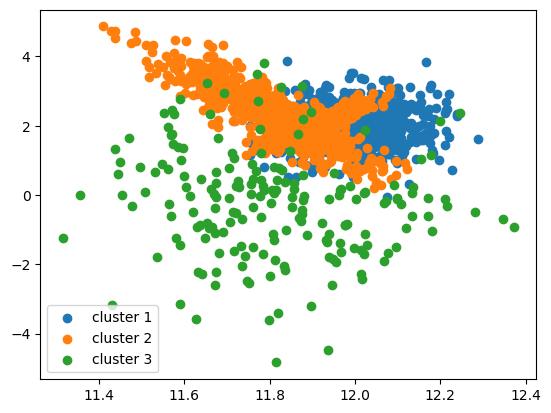

In [312]:
"""
Run the EM algorithm with K=3. 
"""
# YOUR CODE HERE
K = 3
ll, means, covs, class_priors, resp = em(X, K)
print(ll)

corrs = corr(0,1,covs, K)
for corr_ in corrs: print(corr_)

_, counts  = np.unique(np.argmax(resp, axis=1), return_counts=True)
print("num of points assigned to each component")
print(counts)

plot_data_comps(X, resp, K)

converged in 40 iterations
-5989.752406033832
-0.05312687580235182
-0.8943711148900556
0.035862127798583894
0.9153881927590798
[193 575 810 422]


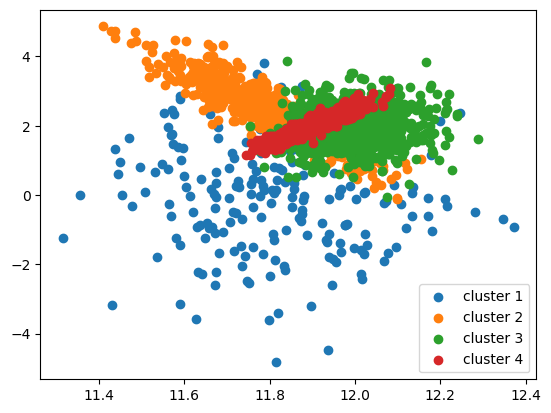

In [313]:
"""
Run the EM algorithm with K=4. 
"""
# YOUR CODE HERE
K = 4
ll, means, covs, class_priors, resp = em(X, K)
print(ll)

corrs = corr(0,1,covs, K)
for corr_ in corrs: print(corr_)

_, counts  = np.unique(np.argmax(resp, axis=1), return_counts=True)
print(counts)

plot_data_comps(X, resp, K)

4. Increase the number of classes to $K=3$ and rerun your algorithm on the data, again trying different random initializations. Plot the ${x_1,x_2}$ coordinates colored according to the most probable component and compute the correlation coefficients of each of the components. Check both your plot and your coefficients if one of the clusters now displays the strong positive $\{x_1, x_2\}$ correlation we are looking for.

    Increase to $K=4$, do the same, and see if this improves your result (in terms of detection of the doping-cluster). Based on your findings, is the rumoured 1-in-5 estimate for users of the drug credible?
    
    **Note:** Please use only the cells allotted for code and explanations.


Yes, for K=4, we seem to detect the doping cluster. In this case, it is cluster 4, which has a correlation coefficient of 0.915, and contains 422 data points. This number is reasonably close to the rumoured estimate of drug users, though somewhat smaller.

Having found the offending cluster in the data using the EM-algorithm, we are now presented with four samples $\{A, B, C, D\}$, with values for $[x_1, x_2, x_3, x_4]$ given as:
\begin{eqnarray*}
\text{A} & = & [11.85, 2.2, 0.5, 4.0] \\
\text{B} & = & [11.95, 3.1, 0.0, 1.0] \\
\text{C} & = & [12.00, 2.5, 0.0, 2.0] \\
\text{D} & = & [12.00, 3.0, 1.0, 6.3]
\end{eqnarray*}
One of these is from a subject who took the performance enhancing drug, and one is from a subject who tried to tamper with the test by artificially altering one or more of the $x_i$ levels in their blood sample.

5. Identify which sample belongs to the suspected user and which one belongs to the 'fraud'. Explain your choices.

In [314]:
# Use this code cell if you need to perform any extra computations, then write your explanation in the text cell below.

YOUR ANSWER HERE